In [1]:
from google.cloud import spanner
import matplotlib.pyplot as plt
import numpy as np

In [2]:
spanner_client = spanner.Client()
instance = spanner_client.instance('ml-models-characterization-db')
database = instance.database('models_db')

/home/shobhitbehl/project/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/shobhitbehl/project/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com

In [3]:
num_models = dict()
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT category, COUNT(model_name) as count'
        ' FROM Models'
        ' GROUP BY category'
    )
    
for row in results:
    num_models[row[0]] = row[1]
    
print(num_models)

{'ImageSegmentation': 2, 'ImageStyleTransfer': 1, 'TextLanguageModel': 1, 'VideoGeneration': 2, 'ImageRNNAgent': 1, 'AudioEmbedding': 1, 'ImageGenerator': 5, 'TextGeneration': 1, 'ImagePoseDetection': 1, 'ObjectDetection': 4, 'TextRetrievalQuestionAnswering': 1, 'TextEmbedding': 4, 'ImageOthers': 1, 'VideoText': 1, 'ImageFeatureVector': 6, 'ImageClassification': 16}


In [4]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT Models.model_name, COUNT(operator_type) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' GROUP BY model_name'
        ' ORDER BY model_name'
    )
    
total_ops = dict()
for row in results:
    total_ops[row[0]] = row[1]
    
print(total_ops)

{'LAReQA_mBERT_En_En_1': 3019, 'MobileNet-V3': 135, 'albert_lite_base_squadv1_1': 2682, 'bigbigan-resnet50_1': 1590, 'biggan-128_2': 212, 'biggan-deep-128_1': 586, 'compare_gan_model_15_cifar10_resnet_cifar_1': 2892, 'deeplabv3_1_default_1': 72, 'delf_1': 491, 'densenet': 251, 'efficientnet_b5_feature-vector_1': 1791, 'efficientnet_b6_feature-vector_1': 2079, 'efficientnet_b7_feature-vector_1': 2549, 'elmo_3': 591, 'faster_rcnn_openimages_v4_inception_resnet_v2_1': 39821, 'ganeval-cifar10-convnet_1': 187, 'inception_resnet_v2': 258, 'inception_v1_224_quant': 85, 'inception_v2_224_quant': 98, 'inception_v3_quant': 127, 'inception_v4_299_quant': 197, 'local-linearity_cifar10_1': 286, 'magenta_arbitrary-image-stylization-v1-256_fp16_prediction_1': 172, 'mil-nce_s3d_1': 603, 'mnasnet_1.3_224': 66, 'mobilebert_1_default_1': 2547, 'mobilenet_v1_1.0_224': 33, 'mobilenet_v2_1.0_224_quant': 67, 'nasnet_large': 899, 'nasnet_mobile': 665, 'object_detection_mobile_object_localizer_v1_1_default_1':

In [5]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT Models.model_name, COUNT(operator_type) AS num_conv2d_layers'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type = \'Conv2D\''
        ' GROUP BY model_name'
        ' ORDER BY num_conv2d_layers DESC;'
    )
    
conv2d_ops = dict()
for row in results:
    conv2d_ops[row[0]] = row[1]

print(conv2d_ops)

{'videoflow_encoder_1': 724, 'nasnet_large': 268, 'faster_rcnn_openimages_v4_inception_resnet_v2_1': 247, 'efficientnet_b7_feature-vector_1': 218, 'nasnet_mobile': 196, 'inception_resnet_v2': 188, 'efficientnet_b6_feature-vector_1': 179, 'efficientnet_b5_feature-vector_1': 155, 'inception_v4_299_quant': 149, 'vision_embedder_inaturalist_V2_1': 149, 'resnet_v2_101_299': 105, 'inception_v3_quant': 95, 'bigbigan-resnet50_1': 94, 'compare_gan_model_15_cifar10_resnet_cifar_1': 92, 'delf_1': 90, 'inception_v2_224_quant': 70, 'densenet': 62, 'inception_v1_224_quant': 58, 'spiral_default-fluid-gansn-celebahq64-gen-19steps_1': 57, 'object_detection_mobile_object_localizer_v1_1_default_1': 55, 'openimages_v4_ssd_mobilenet_v2_1': 55, 'vae_1': 54, 'wae-mmd_1': 54, 'MobileNet-V3': 49, 'biggan-deep-128_1': 45, 'local-linearity_cifar10_1': 40, 'speech_embedding_1': 40, 'deeplabv3_1_default_1': 38, 'magenta_arbitrary-image-stylization-v1-256_fp16_prediction_1': 36, 'mobilenet_v2_1.0_224_quant': 36, 'm

In [6]:
labels = list(total_ops.keys())
values = list()
for label in labels:
    if label not in conv2d_ops:
        values.append(0)
        continue
    values.append((conv2d_ops[label] / total_ops[label]) * 100)

print(labels)
print(values)

['LAReQA_mBERT_En_En_1', 'MobileNet-V3', 'albert_lite_base_squadv1_1', 'bigbigan-resnet50_1', 'biggan-128_2', 'biggan-deep-128_1', 'compare_gan_model_15_cifar10_resnet_cifar_1', 'deeplabv3_1_default_1', 'delf_1', 'densenet', 'efficientnet_b5_feature-vector_1', 'efficientnet_b6_feature-vector_1', 'efficientnet_b7_feature-vector_1', 'elmo_3', 'faster_rcnn_openimages_v4_inception_resnet_v2_1', 'ganeval-cifar10-convnet_1', 'inception_resnet_v2', 'inception_v1_224_quant', 'inception_v2_224_quant', 'inception_v3_quant', 'inception_v4_299_quant', 'local-linearity_cifar10_1', 'magenta_arbitrary-image-stylization-v1-256_fp16_prediction_1', 'mil-nce_s3d_1', 'mnasnet_1.3_224', 'mobilebert_1_default_1', 'mobilenet_v1_1.0_224', 'mobilenet_v2_1.0_224_quant', 'nasnet_large', 'nasnet_mobile', 'object_detection_mobile_object_localizer_v1_1_default_1', 'openimages_v4_ssd_mobilenet_v2_1', 'posenet_mobilenet_float_075_1_default_1', 'progan-128_1', 'resnet_v2_101_299', 'small_bert_bert_uncased_L-4_H-256_A-

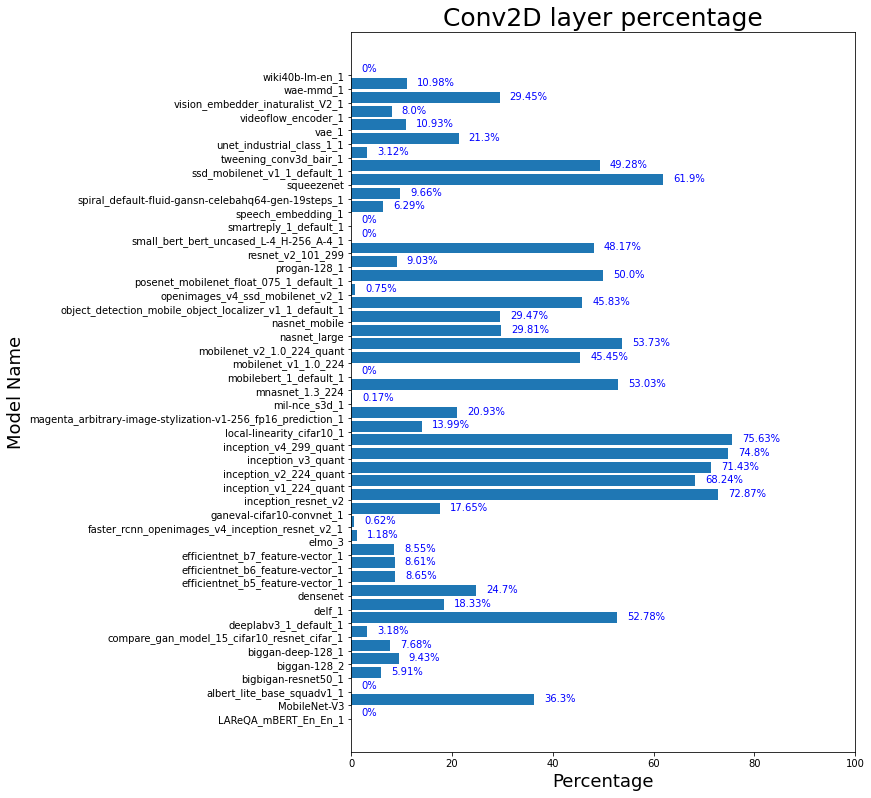

In [7]:
fig = plt.figure(figsize = (7,10))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Conv2D layer percentage", fontsize = 25)
ax.set_xlim([0, 100])
plt.barh(labels, values, align='edge')
ax.set_xlabel('Percentage', fontsize = 18)
ax.set_ylabel('Model Name', fontsize = 18)

for index, value in enumerate(values):
    ax.text(value + 2, index + .25, str(round(value,2)) + "%", color='blue')

plt.show()

In [8]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT category, operator_type, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type NOT IN ("Output_Placeholder", "Placeholder", "Input_Placeholder")'
        ' GROUP BY category, operator_type'
        ' ORDER BY category, count DESC;'
    )
    
category_op_dist = dict()
category_total_ops = dict()

categories = list()

for row in results:
    if row[0] not in categories:
        op_dist = dict()        
        categories.append(row[0])
    op_dist[row[1]] = row[2]
    category_op_dist[row[0]] = op_dist
    
    if row[0] not in category_total_ops:
        category_total_ops[row[0]] = 0

    category_total_ops[row[0]] += row[2]

print(category_op_dist['ImageClassification'])
print(category_op_dist['TextEmbedding'])
print(category_total_ops)

{'Conv2D': 1425, 'DepthwiseConv2dNative': 443, 'Add': 435, 'Relu': 299, 'Concat': 203, 'Mul': 194, 'AveragePool': 166, 'Mean': 91, 'AddV2': 56, 'MaxPool': 53, 'Split': 38, 'Softplus': 37, 'Pow': 37, 'BiasAdd': 33, 'HardSwish': 21, 'Pad': 12, 'Softmax': 9, 'StridedSlice': 8, 'Reshape': 7, 'FULLY_CONNECTED': 6, 'MatMul': 4, 'Squeeze': 1, 'Dequantize': 1, 'QUANTIZE': 1}
{'Reshape': 1490, 'Slice': 1011, 'FULLY_CONNECTED': 941, 'Transpose': 691, 'Add': 582, 'Mul': 518, 'Pack': 235, 'StridedSlice': 186, 'Shape': 115, 'Mean': 70, 'Sub': 68, 'Enter': 45, 'MatMul': 41, 'AddV2': 41, 'Softmax': 40, 'Identity': 35, 'SquaredDifference': 35, 'Rsqrt': 35, 'ExpandDims': 28, 'Tanh': 26, 'Exit': 23, 'Merge': 23, 'ConcatV2': 23, 'NextIteration': 23, 'Switch': 23, 'Cast': 21, 'Pow': 17, 'GreaterEqual': 17, 'Fill': 14, 'Maximum': 14, 'Sigmoid': 14, 'RandomUniform': 13, 'Minimum': 12, 'Range': 12, 'Select': 12, 'Less': 12, 'TensorArrayV3': 10, 'StopGradient': 10, 'Relu': 9, 'BatchMatMulV2': 8, 'Squeeze': 8,

sum 537


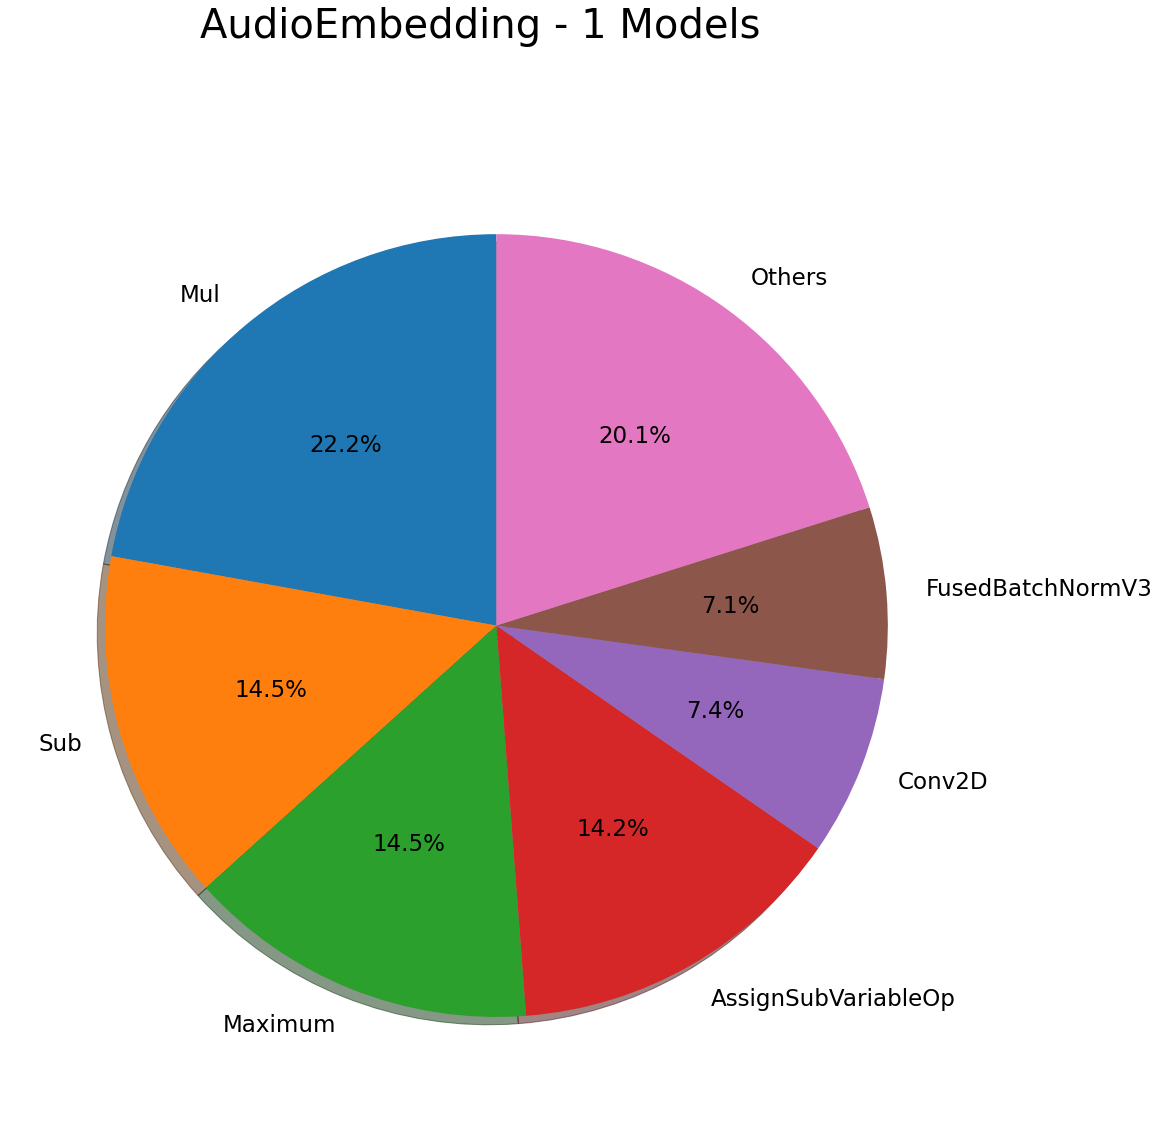

sum 3580


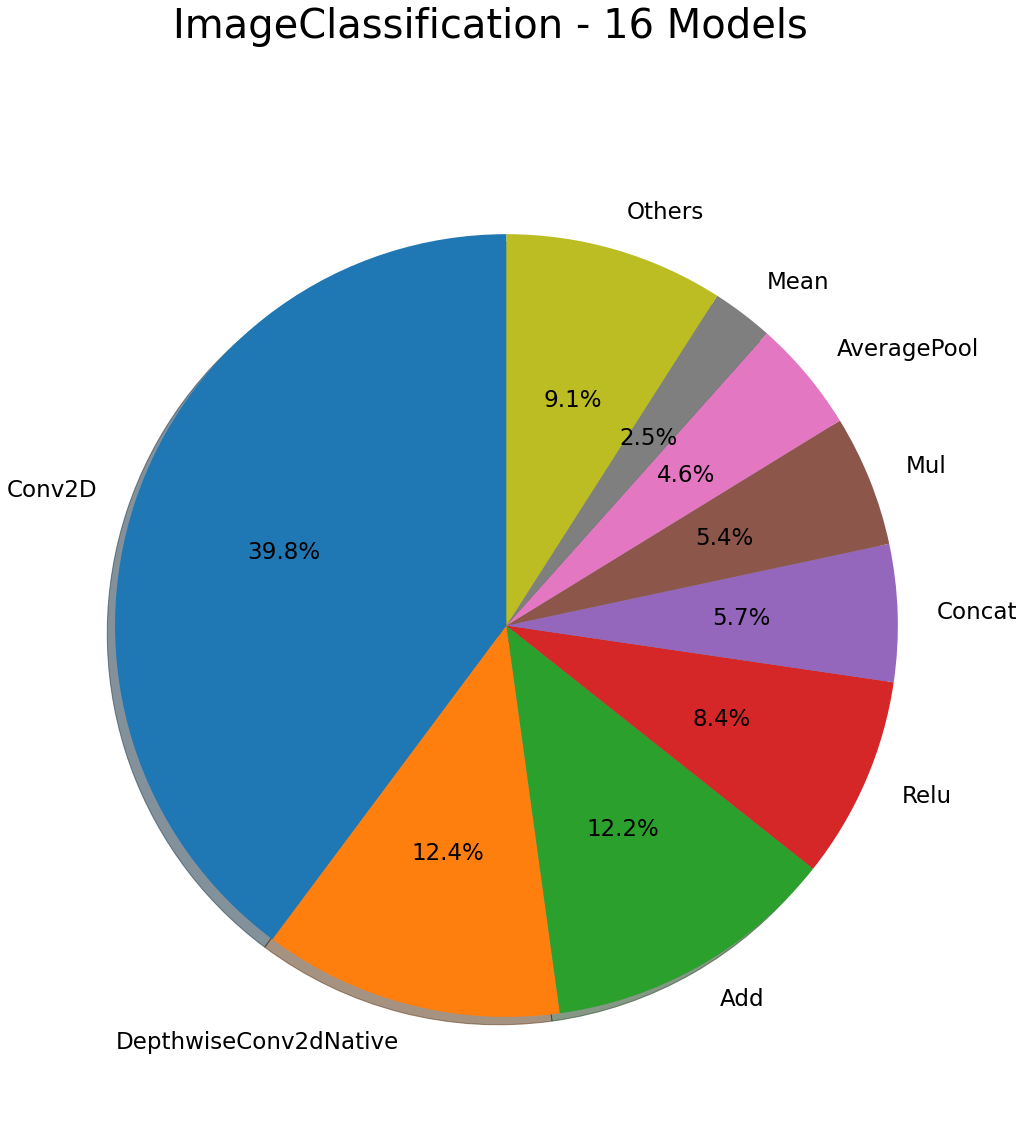

sum 7905


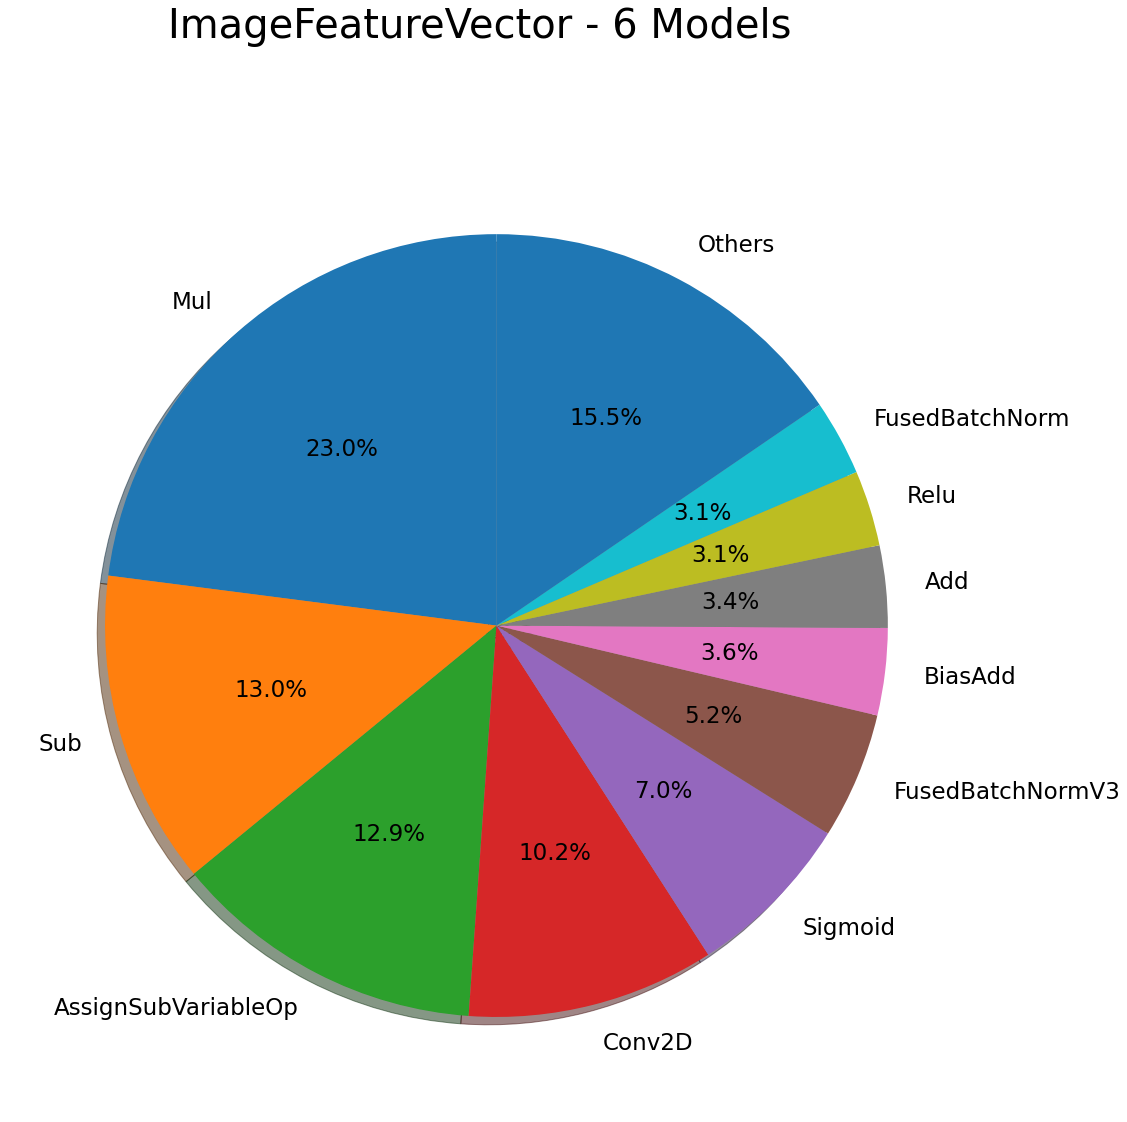

sum 5413


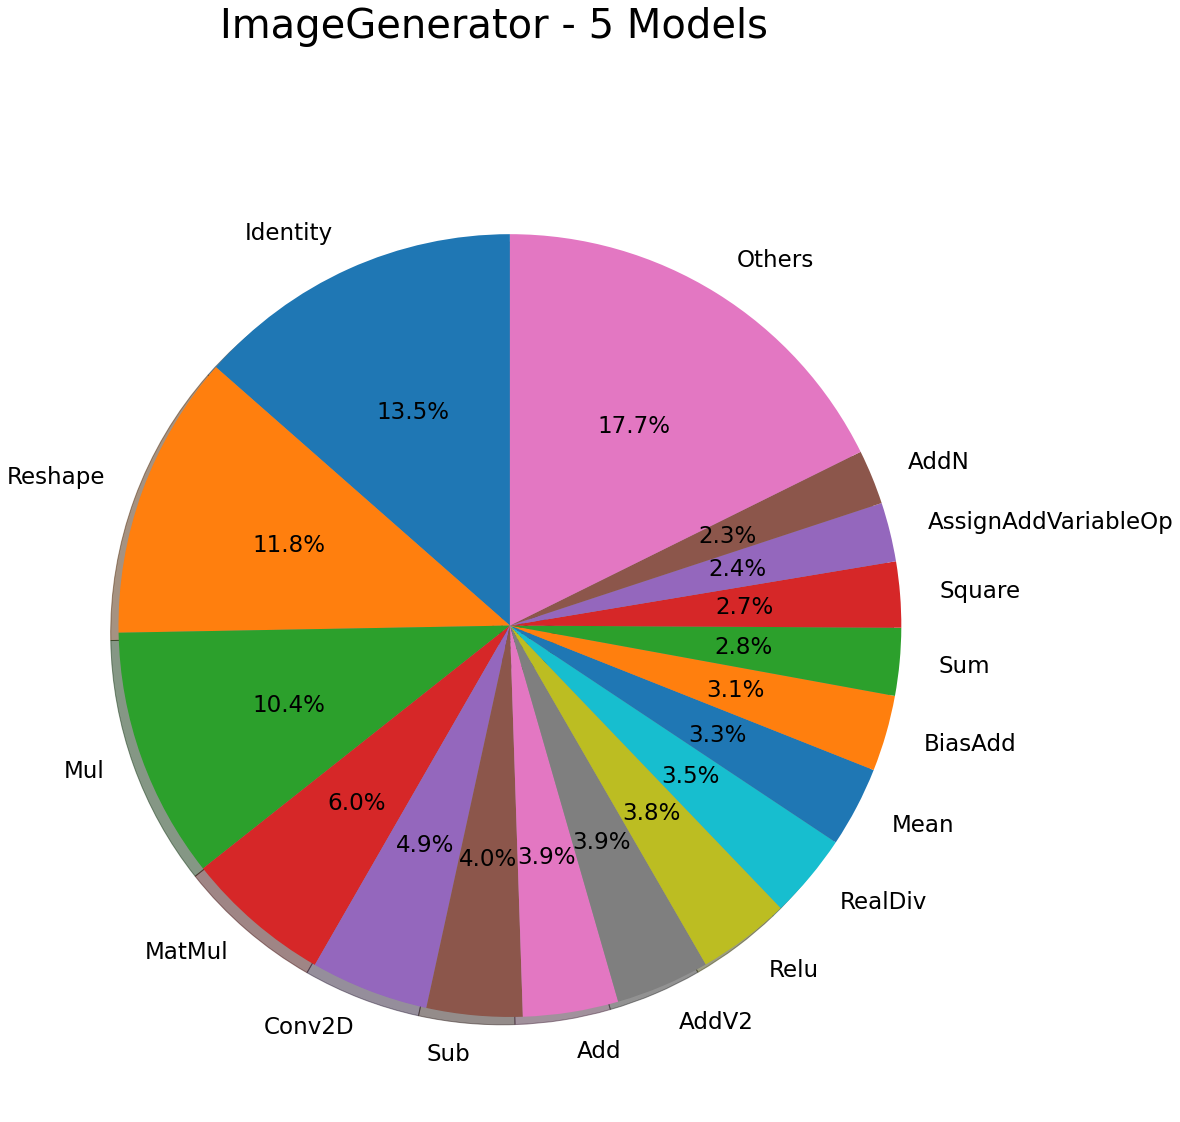

sum 487


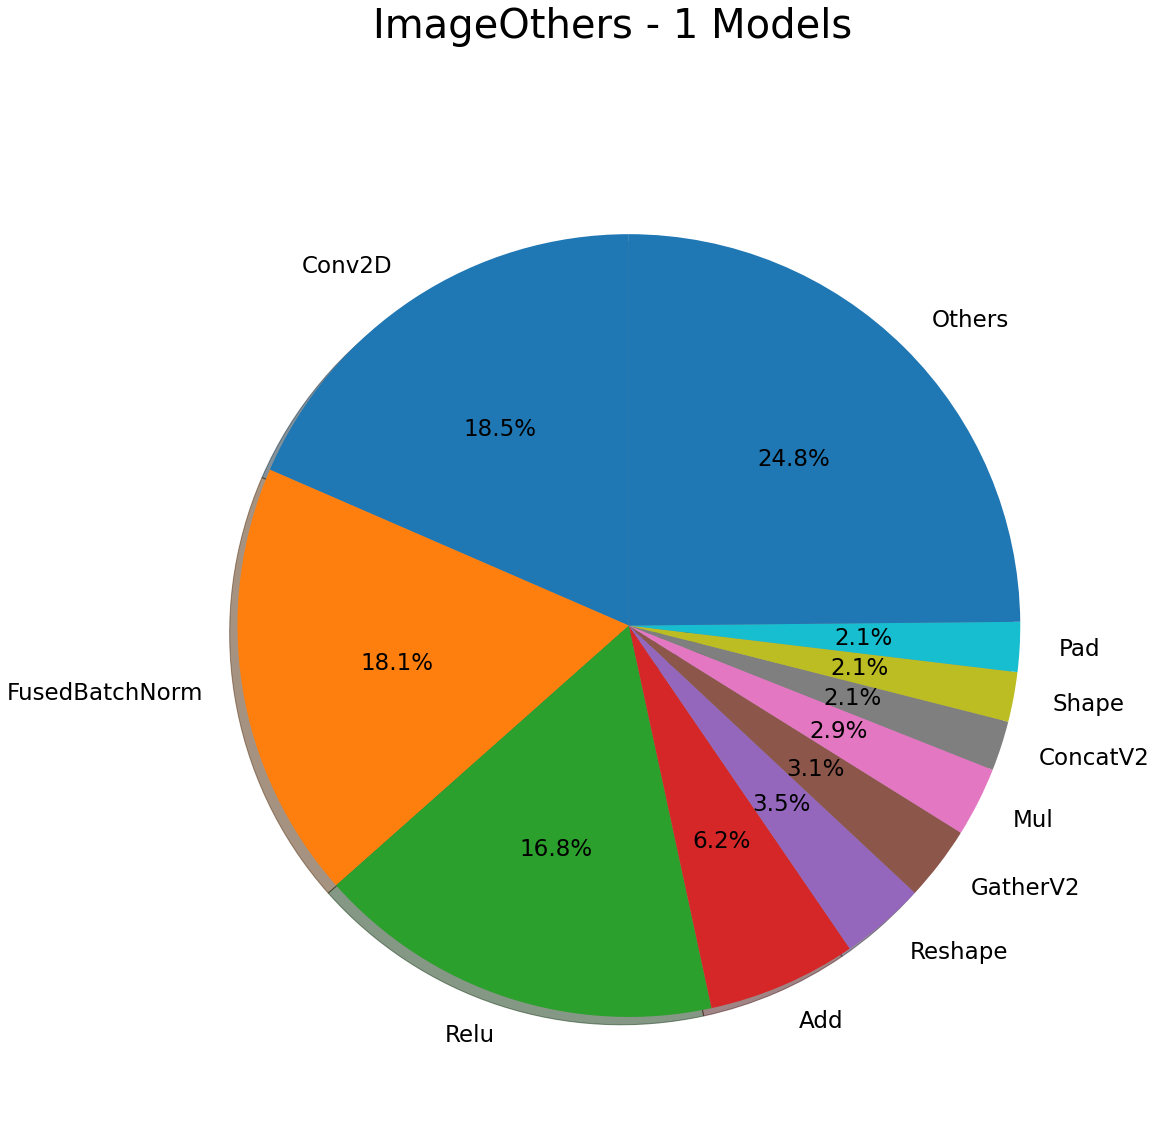

sum 33


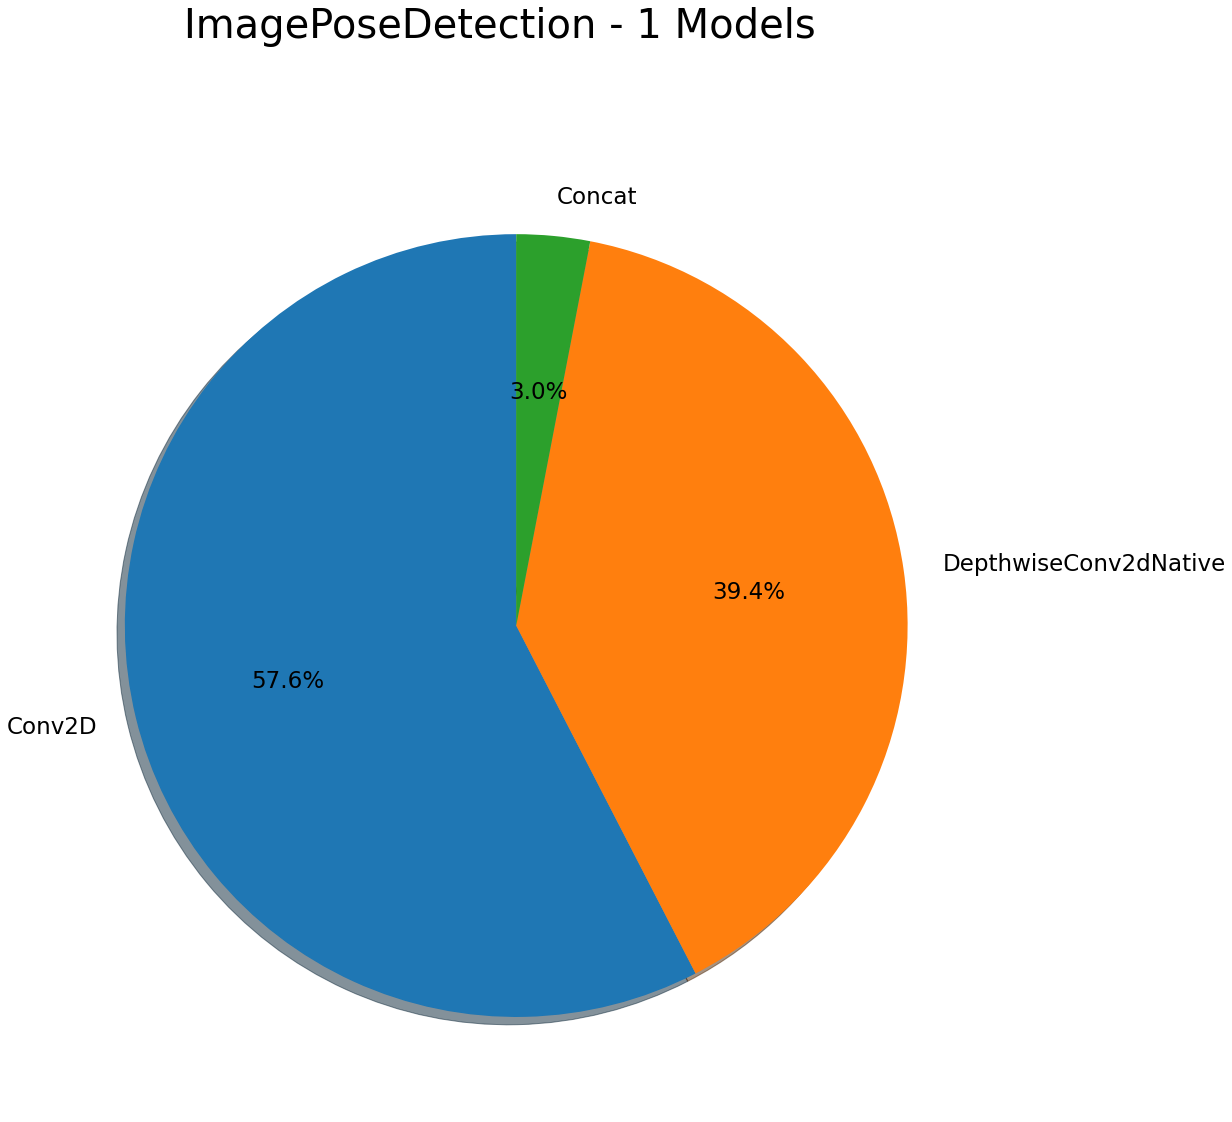

sum 565


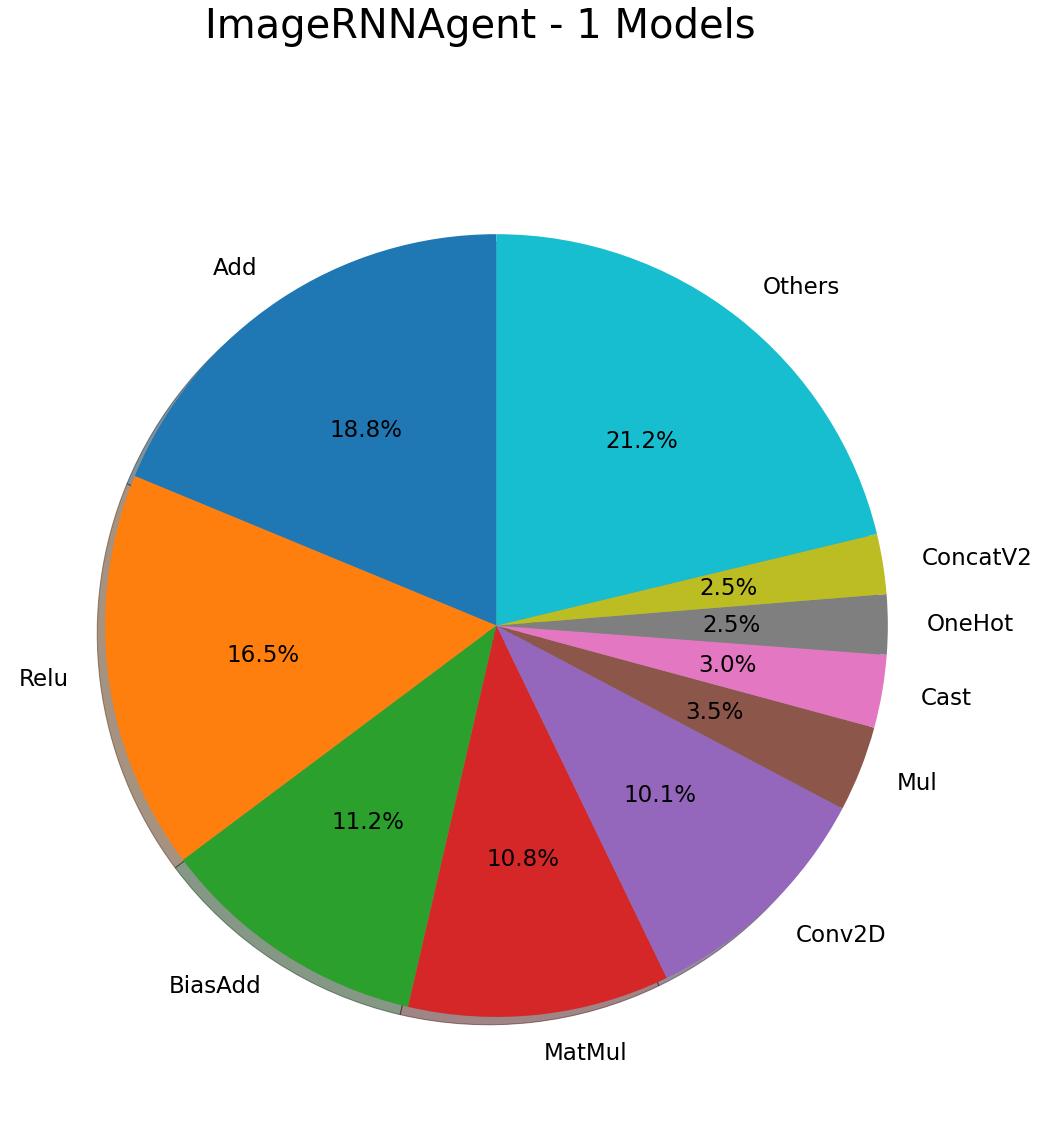

sum 177


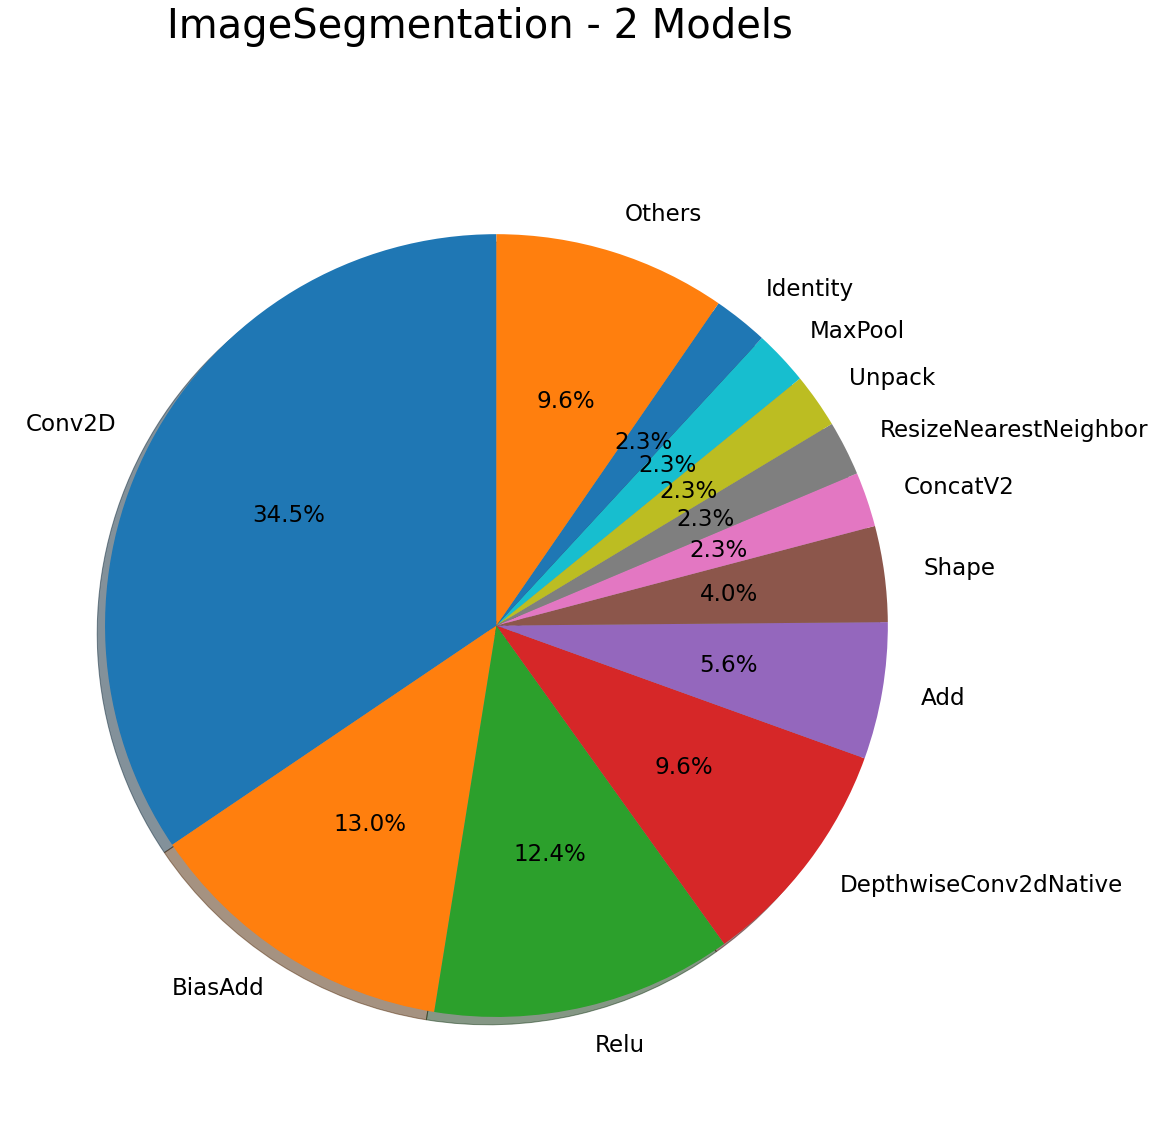

sum 170


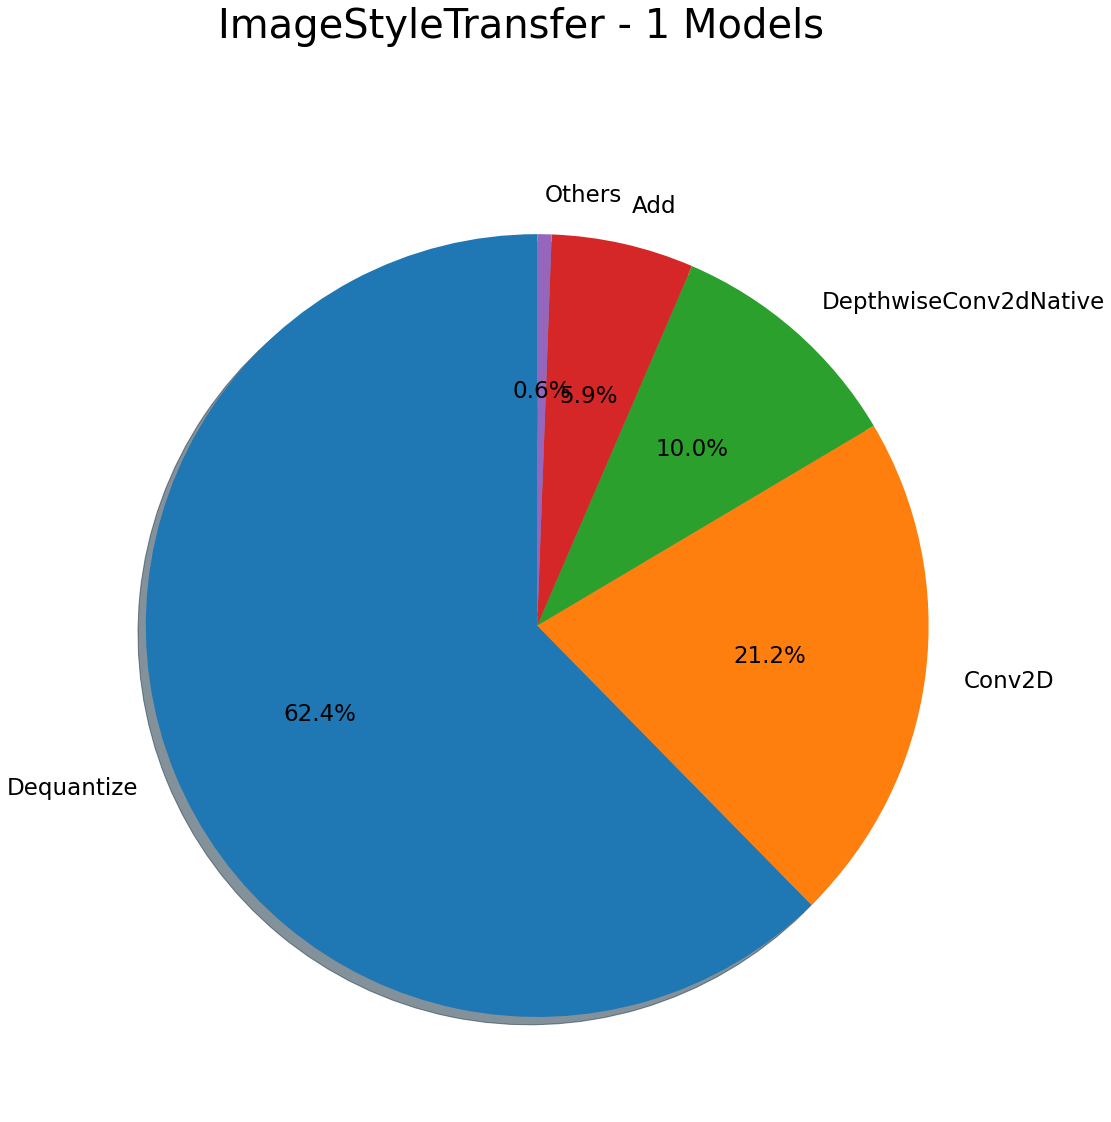

sum 47312


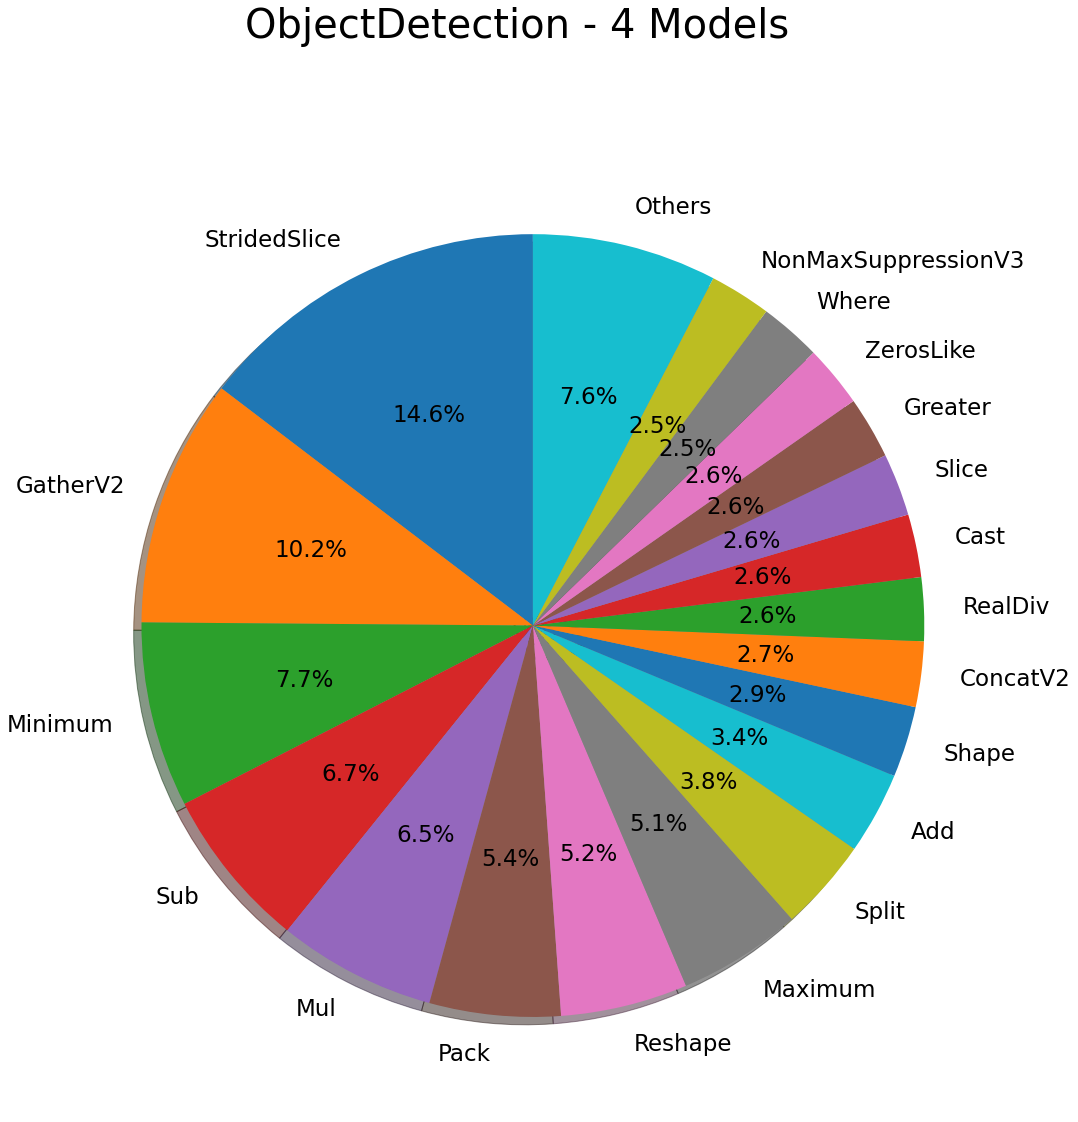

sum 6655


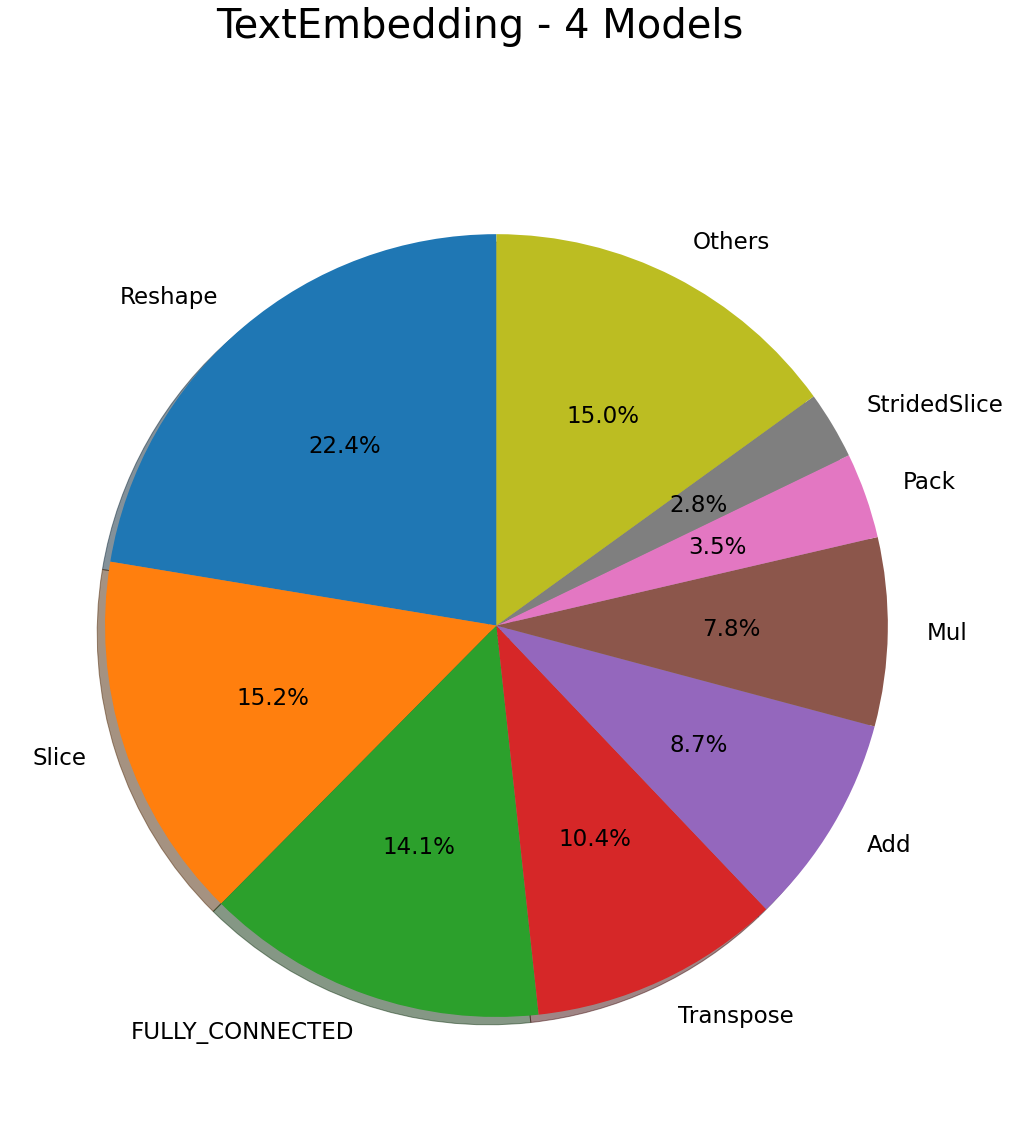

sum 6


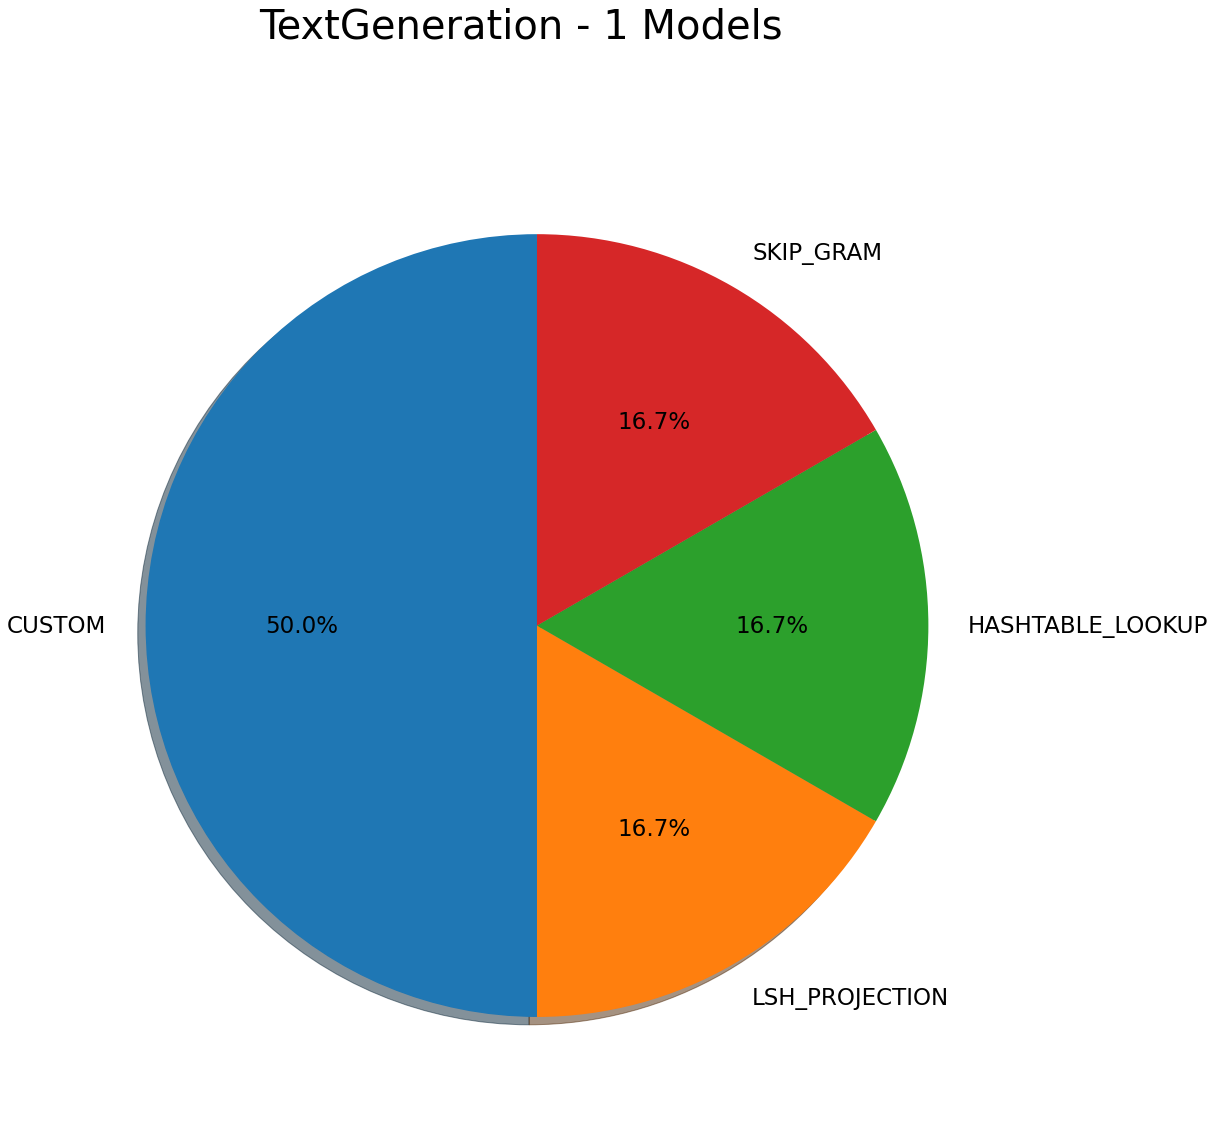

sum 4050


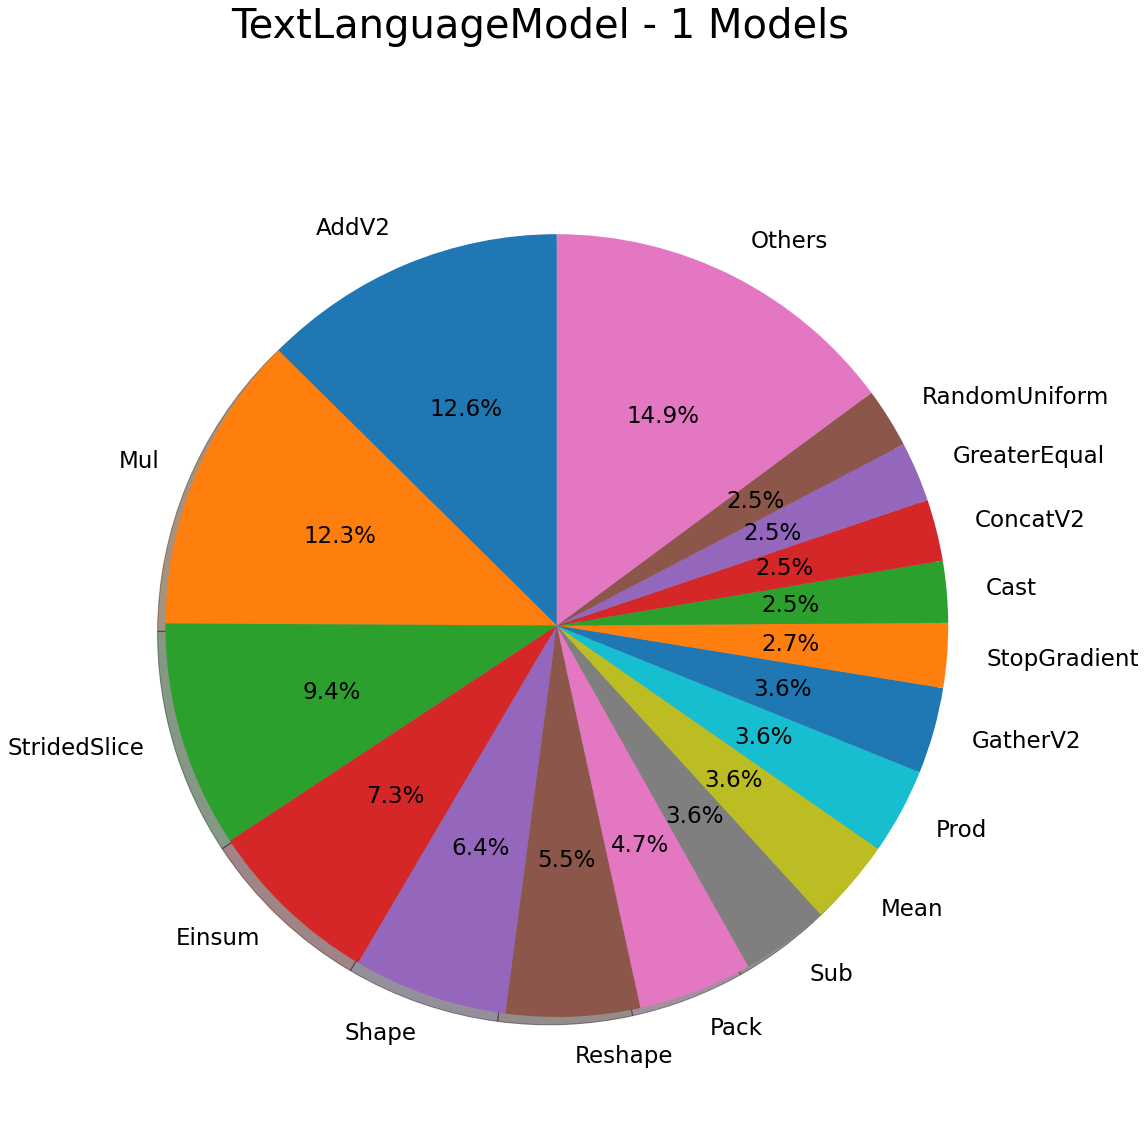

sum 3016


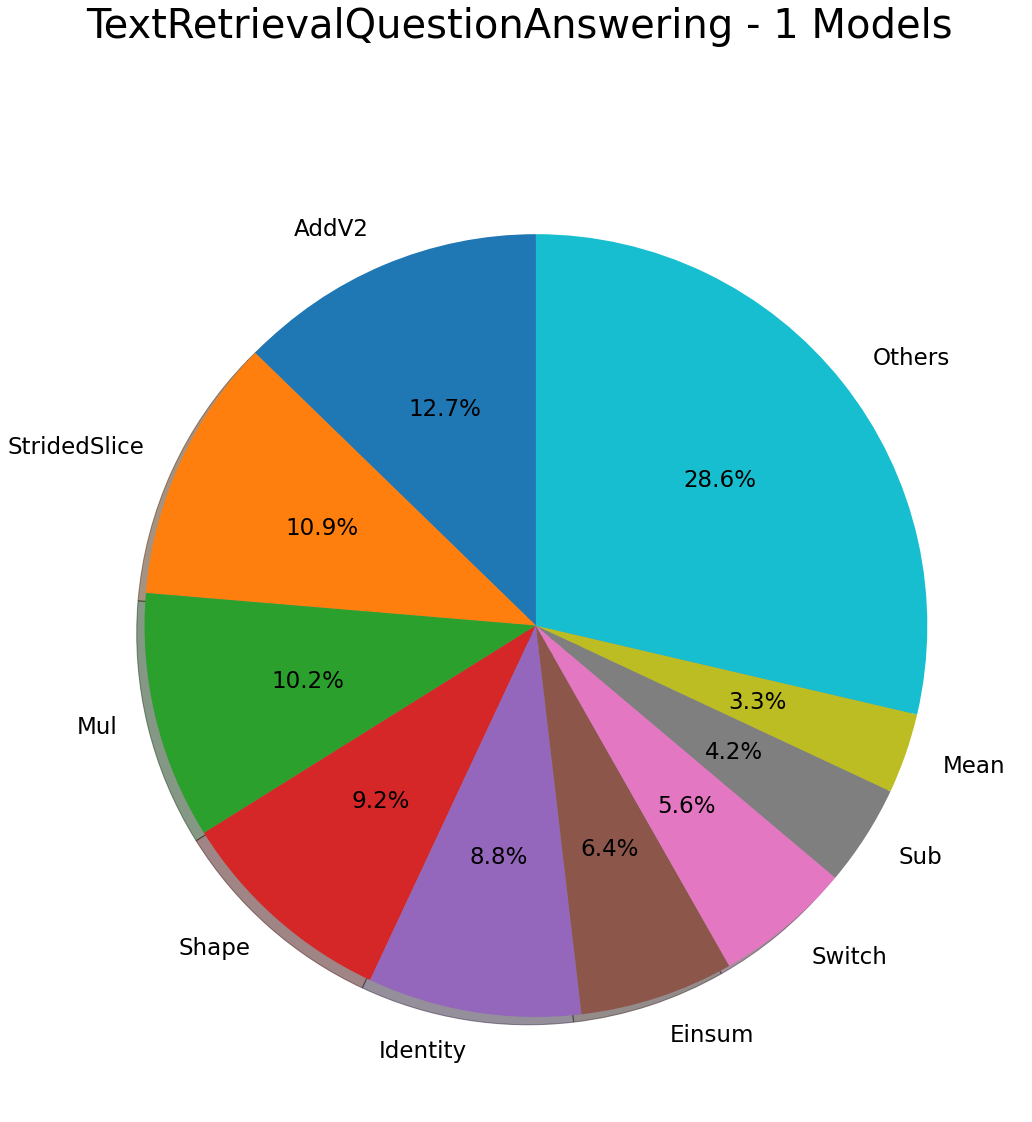

sum 9491


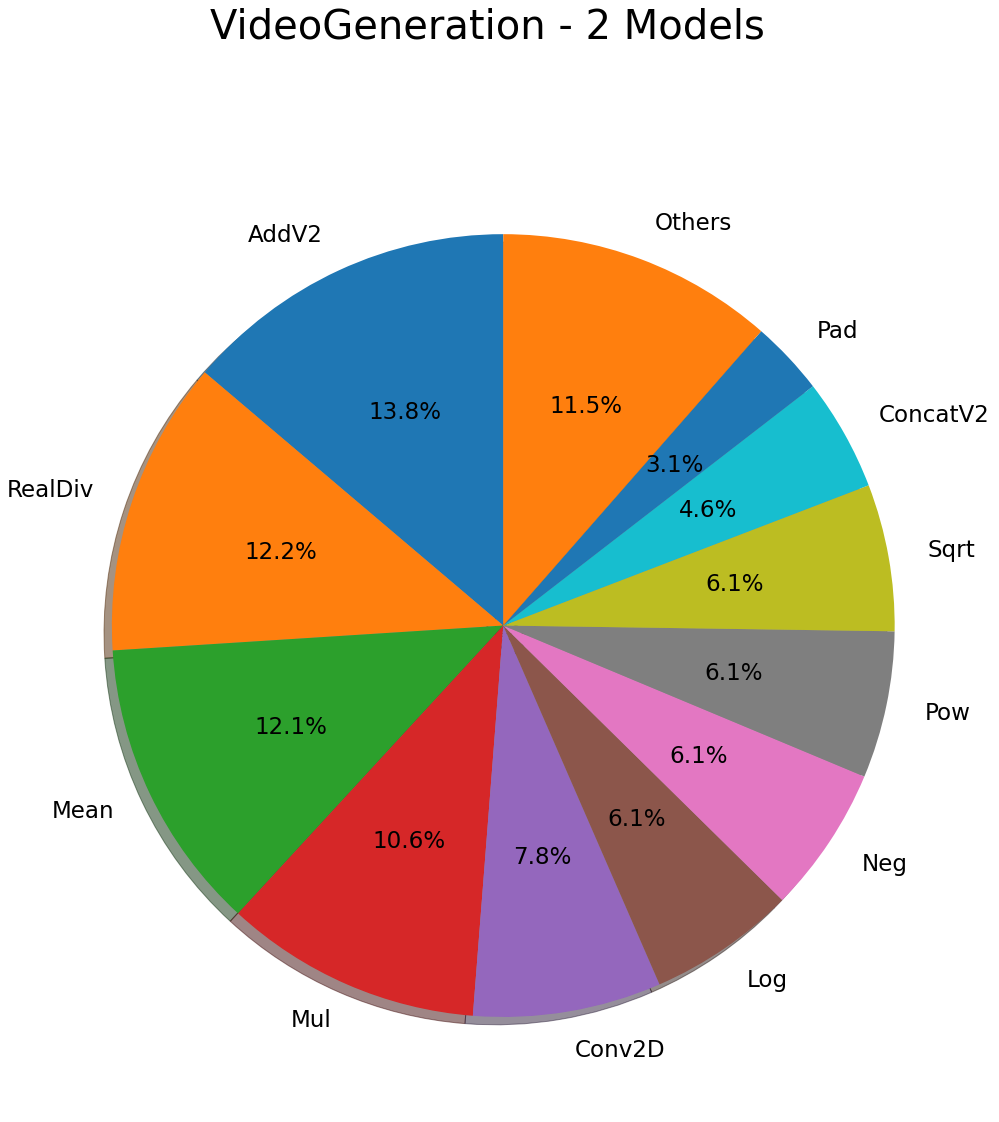

sum 601


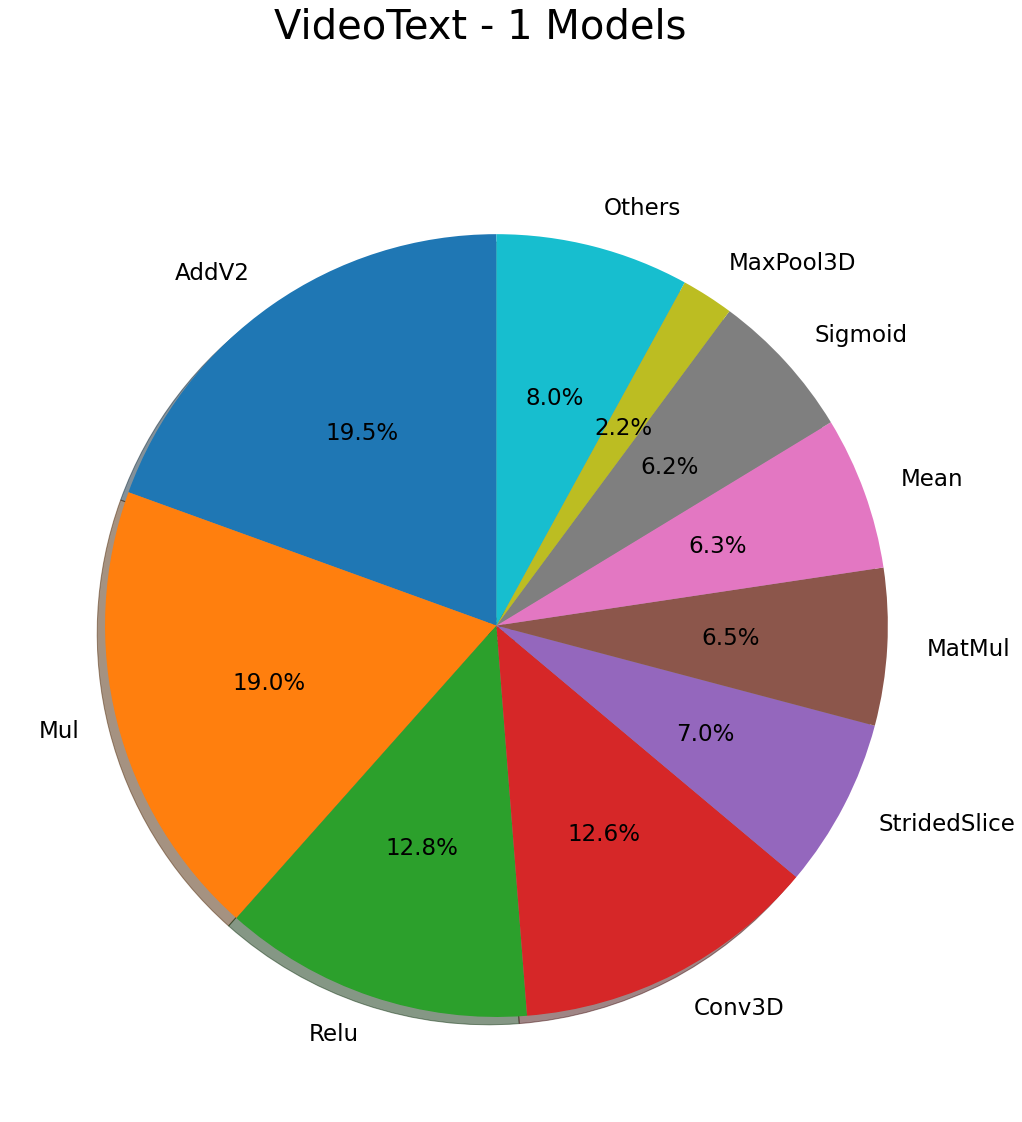

In [9]:
for category in categories:
    labels = list(category_op_dist[category].keys())
    values = list(category_op_dist[category].values())
    
    sum_values = sum(values)
    print("sum" , sum_values)
            
    cumm_val = 0
    for index in reversed(range(len(labels))):
        if values[index] / sum_values > 0.02:
            break
        
        cumm_val += values[index]
        values.pop(index)
        labels.pop(index)
        
    
    if cumm_val != 0:
        labels.append("Others")
        values.append(cumm_val)
    
    fig, ax = plt.subplots(figsize = (18, 18))
    
    ax.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 23})
    fig.suptitle(category + " - " + str(num_models[category]) + " Models", fontsize = '40')
    plt.show()

In [10]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT operator_type, padding, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type NOT IN ("Output_Placeholder", "Input_Placeholder")'
        ' AND padding IS NOT NULL'
        ' GROUP BY operator_type, padding'
        ' ORDER BY operator_type, count DESC;'
    )

In [11]:
operation_padding = dict()

for row in results:
    if row[0] not in operation_padding:
        operation_padding[row[0]] = dict()
        operation_padding[row[0]]['SAME'] = 0
        operation_padding[row[0]]['VALID'] = 0

    operation_padding[row[0]][row[1]] = row[2]
    

labels = list(operation_padding.keys())
same_pad_values = list()
valid_pad_values = list()

for label in labels:
    same_num = operation_padding[label]['SAME']
    valid_num = operation_padding[label]['VALID']
    total = same_num + valid_num
    same_pad_values.append(round((same_num / total) *  100, 2))
    valid_pad_values.append(round((valid_num / total) * 100, 2))

print(labels)
print(same_pad_values)
print(valid_pad_values)

['AveragePool', 'AvgPool', 'Conv2D', 'DepthwiseConv2dNative', 'MaxPool']
[83.83, 78.0, 67.32, 100.0, 41.9]
[16.17, 22.0, 32.68, 0.0, 58.1]


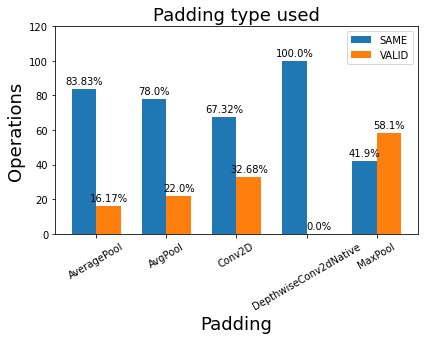

In [12]:
fig, ax = plt.subplots()

x = np.arange(len(labels))  # the label locations
width = 0.35
rects1 = ax.bar(x - width/2, same_pad_values, width, label='SAME')
rects2 = ax.bar(x + width/2, valid_pad_values, width, label='VALID')

ax.set_ylabel('Operations', fontsize = 18)
ax.set_xlabel('Padding', fontsize = 18)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_title("Padding type used", fontsize = 18)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height) + "%",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.xticks(rotation=30)

ax.set_ylim([0, 120])

plt.show()


In [13]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT activation_function, COUNT(operator_type) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE activation_function IS NOT NULL AND activation_function != "NONE"'
        ' GROUP BY activation_function'
        ' ORDER BY count DESC;'
    )

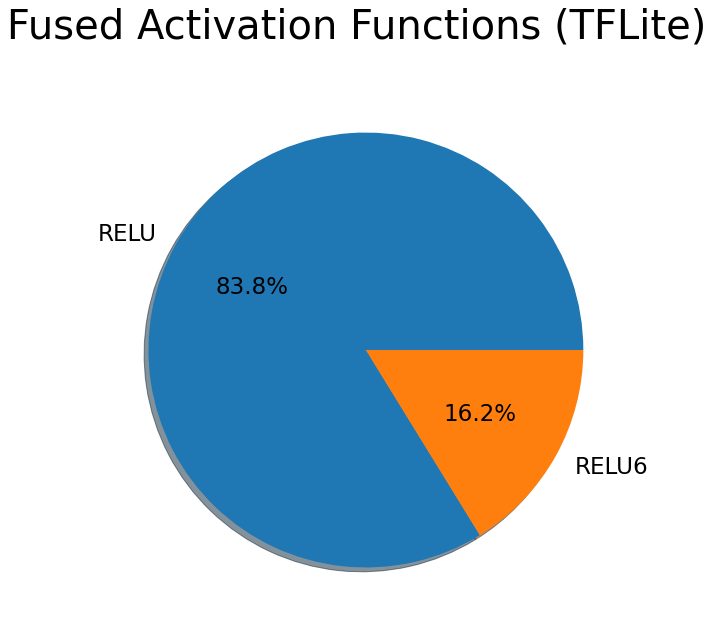

In [14]:
fused_activation_count = dict()
total_count = 0

for row in results:
    fused_activation_count[row[0]] = row[1]
    total_count += row[1]
    
labels = list(fused_activation_count.keys())
values = list(fused_activation_count.values())

fig, ax = plt.subplots(figsize = (10, 10))
ax.pie(values, labels = labels, autopct='%1.1f%%', shadow=True, startangle=0, textprops={'fontsize': 23})
fig.suptitle("Fused Activation Functions (TFLite)", fontsize = '40')
plt.show()

In [15]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT operator_type, COUNT(operator_id) as count'
        ' FROM Operators'
        ' WHERE operator_type IN' 
        ' ("Relu", "Relu6", "Sigmoid", "Elu", "Selu", "Softplus", "Softsign", "Tanh")'
        ' GROUP BY operator_type'
        ' ORDER BY count DESC;'
    )

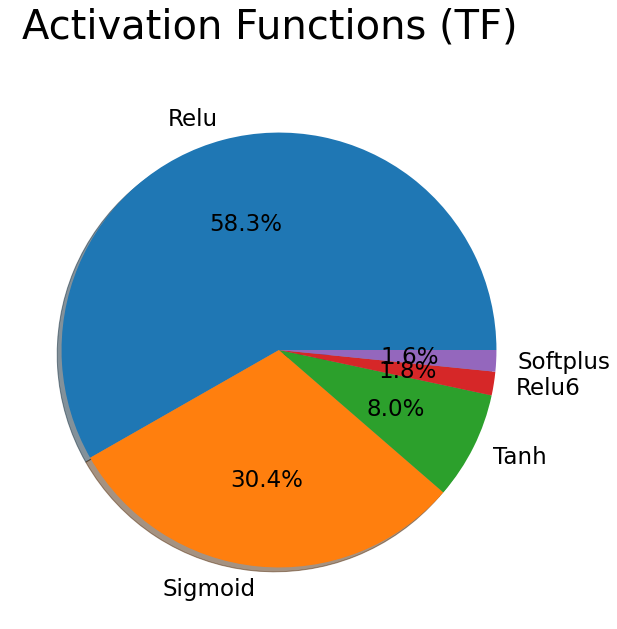

In [16]:
activation_count = dict()
total_count = 0

for row in results:
    activation_count[row[0]] = row[1]
    total_count += row[1]
    
labels = list(activation_count.keys())
values = list(activation_count.values())

fig, ax = plt.subplots(figsize = (10, 10))
ax.pie(values, labels = labels, autopct='%1.1f%%', shadow=True, startangle=0, textprops={'fontsize': 23})
fig.suptitle("Activation Functions (TF)", fontsize = '40')
plt.show()

In [17]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT category, operator_type, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators ON Models.model_name = Operators.model_name'
        ' WHERE operator_type IN' 
        ' ("Relu", "Relu6", "Sigmoid", "Elu", "Selu", "Softplus", "Softsign", "Tanh")'
        ' GROUP BY category, operator_type'
        ' ORDER BY count DESC;'
    )

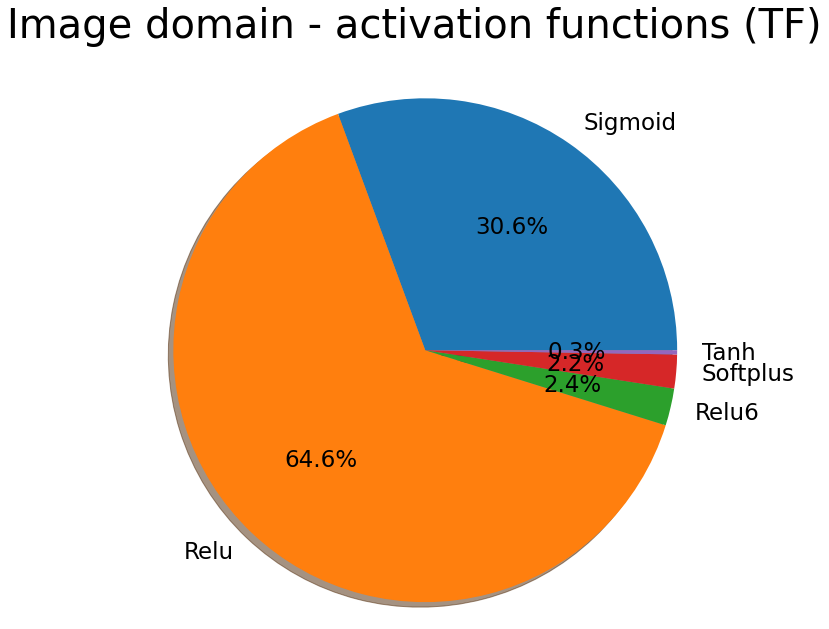

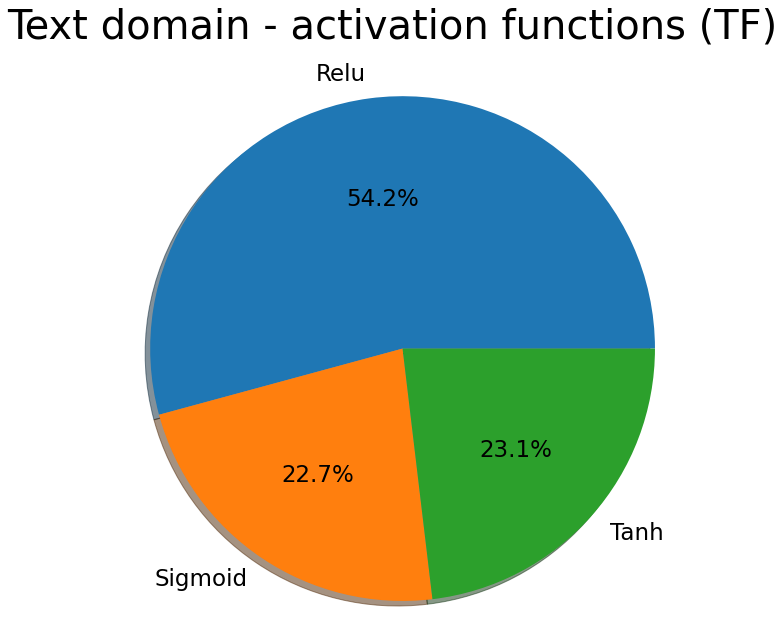

In [18]:
categories = list()
activation_data = dict()
activation_data.update({"Image" : dict()})
activation_data.update({"Text" : dict()})

for row in results:
    
    if "Image" in row[0] or row[0] == "ObjectDetection":
        if row[1] not in activation_data["Image"]:
            activation_data["Image"].update({row[1] : 0})
        activation_data["Image"][row[1]] += row[2]
    elif "Text" in row[0]:
        if row[1] not in activation_data["Text"]:
            activation_data["Text"].update({row[1] : 0})
        activation_data["Text"][row[1]] += row[2]

for key in activation_data.keys():
    
    labels = list(activation_data[key].keys())
    values = list(activation_data[key].values())
    
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.pie(values, labels = labels,
           autopct='%1.1f%%', shadow=True, startangle=0, textprops={'fontsize': 23})
    ax.axis('equal')
    fig.suptitle(key + " domain - activation functions (TF)", fontsize = '40')
    plt.show()